Cars Classification

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.optim as optim

from tqdm import tqdm
import random
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from PIL import Image

%matplotlib inline

In [2]:
plt.style.use('ggplot')
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [3]:
# Seed for repeating the experiments with same results (for random values, etc.)
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [4]:
# Device for training the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
# Crating the model
model = models.resnet18(pretrained=True)

num_classes = 5
model.fc = nn.Linear(model.fc.in_features, num_classes)

C:\Users\jekas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\jekas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
train_data_dir = 'carsdataset/train'
validation_data_dir = 'carsdataset/validation'

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

validation_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Creating datasets
train_dataset = ImageFolder(train_data_dir, transform=train_transforms)
validation_dataset = ImageFolder(validation_data_dir, transform=validation_transforms)

# Creating batches
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

In [7]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 2261
    Root location: carsdataset/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [8]:
# Picture size
train_dataset[20][0].shape

torch.Size([3, 224, 224])

In [9]:
validation_dataset

Dataset ImageFolder
    Number of datapoints: 548
    Root location: carsdataset/validation
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [10]:
classes_list = train_dataset.classes
print(classes_list)

['Audi', 'Hyundai', 'Rolls Royce', 'Suzuki', 'Tata']


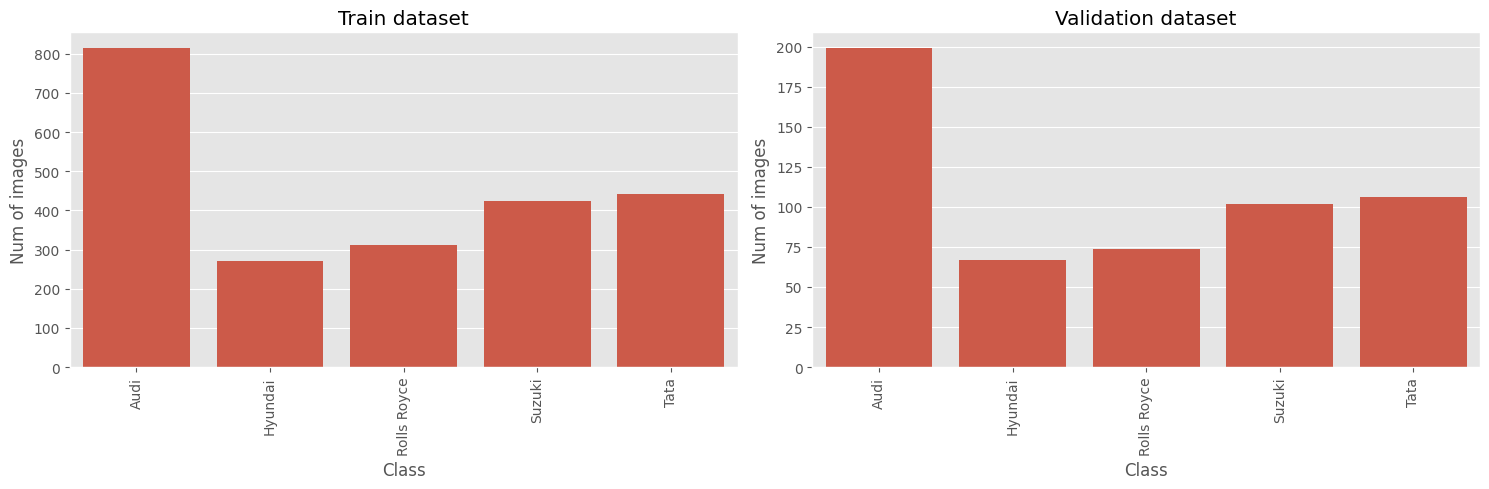

In [11]:
# Count of images for each class in train dataset 
train_class_counts = np.zeros(len(train_dataset.classes))
for _, label in train_dataset:
    train_class_counts[label] += 1
    
# Count of images for each class in validation dataset
validation_class_counts = np.zeros(len(validation_dataset.classes))
for _, label in validation_dataset:
    validation_class_counts[label] += 1
    
    
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.barplot(x=train_dataset.classes, y=train_class_counts, ax=ax[0])
ax[0].set_title('Train dataset')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Num of images')
ax[0].tick_params(axis='x', rotation=90)

sns.barplot(x=validation_dataset.classes, y=validation_class_counts, ax=ax[1])
ax[1].set_title('Validation dataset')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Num of images')
ax[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

Images without normalization:


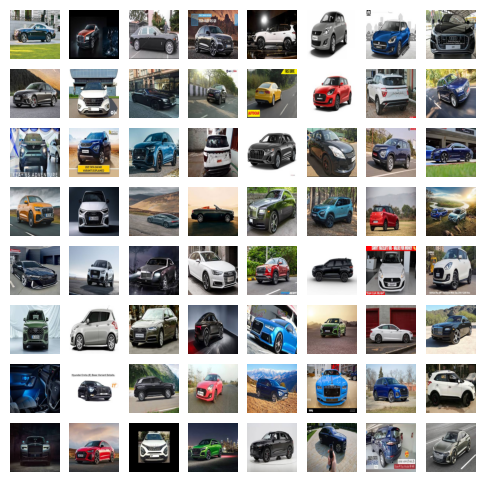

In [12]:
# Function for showing images from batch
def show_images(images, denormalize=False):
    if denormalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        images = images.numpy().transpose((0, 2, 3, 1))
        images = std * images + mean
        images = np.clip(images, 0, 1)
    else:
        images = images.numpy().transpose((0, 2, 3, 1))
    fig, axes = plt.subplots(8, 8, figsize=(6, 6))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.axis('off')
    plt.show()
    
images, _ = next(iter(train_loader))

print('Images without normalization:')
show_images(images, denormalize=False)

In [13]:
len(train_loader), len(validation_loader)

(36, 9)

['Audi', 'Hyundai', 'Rolls Royce', 'Suzuki', 'Tata']

In [14]:
# Objects in batch
next(iter(train_loader))[1]

tensor([0, 3, 0, 0, 0, 0, 2, 0, 0, 3, 4, 1, 2, 0, 1, 2, 3, 4, 4, 0, 0, 0, 4, 4,
        1, 0, 3, 1, 2, 1, 3, 3, 0, 4, 0, 3, 0, 0, 0, 0, 3, 3, 3, 3, 0, 4, 3, 4,
        2, 0, 3, 3, 2, 0, 0, 2, 1, 2, 1, 3, 0, 0, 4, 2])

In [15]:
# Validation of the model before training
model.eval()
model.to(device)
correct = 0
total = 0
with torch.no_grad():
    for images, labels in tqdm(validation_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        print(outputs.shape)
        _, predicted = outputs.max(1)
        print(predicted)
        print(labels)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
validation_accuracy = correct / total
print(validation_accuracy)

 11%|█         | 1/9 [00:00<00:04,  1.79it/s]

torch.Size([64, 5])
tensor([4, 3, 3, 1, 1, 3, 0, 0, 0, 3, 1, 4, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 4, 3,
        3, 3, 3, 4, 3, 4, 3, 0, 3, 3, 3, 4, 3, 3, 3, 3, 1, 3, 0, 3, 0, 0, 3, 3,
        3, 3, 3, 1, 3, 3, 0, 3, 3, 4, 3, 0, 0, 3, 3, 3], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
torch.Size([64, 5])
tensor([3, 3, 0, 3, 0, 4, 0, 3, 3, 3, 3, 3, 3, 3, 4, 3, 1, 3, 0, 3, 3, 3, 4, 4,
        3, 3, 3, 3, 4, 3, 0, 4, 0, 4, 3, 0, 3, 3, 0, 3, 1, 0, 3, 4, 4, 0, 3, 3,
        3, 3, 0, 1, 3, 3, 3, 0, 3, 0, 3, 1, 3, 4, 1, 4], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


 44%|████▍     | 4/9 [00:01<00:01,  4.92it/s]

torch.Size([64, 5])
tensor([3, 3, 1, 4, 3, 3, 4, 1, 3, 4, 0, 1, 4, 1, 3, 0, 1, 3, 0, 0, 3, 4, 3, 4,
        0, 1, 0, 0, 3, 3, 3, 3, 3, 0, 3, 3, 0, 4, 0, 4, 1, 3, 3, 3, 3, 4, 4, 0,
        0, 3, 0, 0, 3, 0, 3, 4, 3, 0, 4, 0, 3, 3, 3, 3], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
torch.Size([64, 5])
tensor([3, 3, 4, 4, 1, 4, 3, 3, 3, 0, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 0, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')


 56%|█████▌    | 5/9 [00:01<00:00,  5.49it/s]

torch.Size([64, 5])
tensor([4, 3, 3, 4, 3, 3, 3, 3, 3, 3, 0, 0, 3, 3, 0, 3, 3, 1, 4, 0, 1, 3, 0, 4,
        4, 1, 3, 3, 0, 3, 3, 3, 0, 3, 3, 1, 0, 3, 1, 1, 0, 0, 3, 3, 1, 0, 0, 1,
        3, 0, 1, 3, 0, 3, 3, 4, 3, 0, 3, 0, 1, 4, 3, 3], device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
torch.Size([64, 5])
tensor([0, 3, 3, 3, 0, 3, 3, 4, 1, 4, 1, 3, 3, 3, 4, 0, 0, 0, 3, 1, 3, 3, 3, 0,
        3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 0, 3, 3, 3, 0, 1, 3, 3, 4, 3, 3, 3, 3, 0,
        3, 3, 4, 1, 4, 0, 3, 4, 3, 3, 4, 3, 3, 3, 3, 3], device='cuda:0')
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')


 78%|███████▊  | 7/9 [00:01<00:00,  6.21it/s]

torch.Size([64, 5])
tensor([3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 4, 4, 3, 3, 3, 3, 4, 3, 3, 3,
        1, 3, 3, 3, 3, 3, 1, 0, 3, 3, 3, 3, 3, 3, 3, 4, 3, 0, 3, 3, 3, 3, 4, 3,
        1, 3, 3, 3, 3, 0, 3, 3, 1, 3, 3, 3, 4, 3, 3, 3], device='cuda:0')
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4], device='cuda:0')
torch.Size([64, 5])
tensor([3, 3, 3, 3, 3, 4, 0, 3, 3, 3, 4, 3, 4, 3, 0, 3, 3, 4, 3, 3, 3, 3, 3, 4,
        4, 3, 4, 3, 0, 0, 3, 3, 4, 4, 3, 3, 3, 3, 1, 4, 0, 3, 1, 3, 4, 0, 4, 3,
        4, 1, 0, 3, 3, 3, 3, 0, 4, 0, 4, 3, 0, 4, 3, 4], device='cuda:0')
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], device='cuda:0')


100%|██████████| 9/9 [00:01<00:00,  5.28it/s]

torch.Size([36, 5])
tensor([3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 4, 4, 0, 3, 3, 3, 3,
        3, 4, 3, 3, 3, 3, 0, 4, 4, 4, 3, 0], device='cuda:0')
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], device='cuda:0')
0.26277372262773724


Training the model

In [16]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

num_epochs = 30

train_losses = []
train_accuracies = []

validation_losses = []
validation_accuracies = []
best_validation_accuracy = 0

model.to(device)


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Model validation
    model.eval()
    validation_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(validation_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            validation_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
    validation_loss /= len(validation_loader)
    validation_accuracy = correct / total
    validation_losses.append(validation_loss)
    validation_accuracies.append(validation_accuracy)
    
    print(f'Epoch {epoch + 1}/{num_epochs}', 
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}',
          f'Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}')
    
    # Saving the best model relying on validation accuracy
    if validation_accuracy > best_validation_accuracy:
        best_validation_accuracy = validation_accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        print('Best model saved')
        
    # Saving the last model
    torch.save(model.state_dict(), 'last_model.pth')
    print()
    
print('\nTraining and validation are finished!')
    
    
    

100%|██████████| 9/9 [00:01<00:00,  7.01it/s]


Epoch 1/30 Train Loss: 0.4565, Train Accuracy: 0.8346 Validation Loss: 0.2872, Validation Accuracy: 0.8978
Best model saved



100%|██████████| 9/9 [00:01<00:00,  8.22it/s]


Epoch 2/30 Train Loss: 0.0664, Train Accuracy: 0.9810 Validation Loss: 0.3248, Validation Accuracy: 0.8923



100%|██████████| 9/9 [00:01<00:00,  8.30it/s]


Epoch 3/30 Train Loss: 0.0271, Train Accuracy: 0.9938 Validation Loss: 0.0979, Validation Accuracy: 0.9653
Best model saved



100%|██████████| 9/9 [00:01<00:00,  7.50it/s]


Epoch 4/30 Train Loss: 0.0108, Train Accuracy: 0.9973 Validation Loss: 0.1451, Validation Accuracy: 0.9580



100%|██████████| 9/9 [00:01<00:00,  7.97it/s]


Epoch 5/30 Train Loss: 0.0082, Train Accuracy: 0.9969 Validation Loss: 0.1201, Validation Accuracy: 0.9635



100%|██████████| 9/9 [00:01<00:00,  8.33it/s]


Epoch 6/30 Train Loss: 0.0196, Train Accuracy: 0.9965 Validation Loss: 0.2512, Validation Accuracy: 0.9380



100%|██████████| 9/9 [00:01<00:00,  8.27it/s]


Epoch 7/30 Train Loss: 0.0374, Train Accuracy: 0.9894 Validation Loss: 0.7282, Validation Accuracy: 0.8449



100%|██████████| 9/9 [00:01<00:00,  8.24it/s]


Epoch 8/30 Train Loss: 0.0732, Train Accuracy: 0.9757 Validation Loss: 0.3845, Validation Accuracy: 0.9106



100%|██████████| 9/9 [00:01<00:00,  8.19it/s]


Epoch 9/30 Train Loss: 0.0463, Train Accuracy: 0.9858 Validation Loss: 0.2671, Validation Accuracy: 0.9161



100%|██████████| 9/9 [00:01<00:00,  8.14it/s]


Epoch 10/30 Train Loss: 0.0292, Train Accuracy: 0.9903 Validation Loss: 0.1336, Validation Accuracy: 0.9562



100%|██████████| 9/9 [00:01<00:00,  8.08it/s]


Epoch 11/30 Train Loss: 0.0102, Train Accuracy: 0.9982 Validation Loss: 0.0782, Validation Accuracy: 0.9690
Best model saved



100%|██████████| 9/9 [00:01<00:00,  8.35it/s]


Epoch 12/30 Train Loss: 0.0029, Train Accuracy: 0.9996 Validation Loss: 0.0575, Validation Accuracy: 0.9818
Best model saved



100%|██████████| 9/9 [00:01<00:00,  8.30it/s]


Epoch 13/30 Train Loss: 0.0009, Train Accuracy: 1.0000 Validation Loss: 0.0352, Validation Accuracy: 0.9872
Best model saved



100%|██████████| 9/9 [00:01<00:00,  7.16it/s]


Epoch 14/30 Train Loss: 0.0012, Train Accuracy: 1.0000 Validation Loss: 0.0370, Validation Accuracy: 0.9891
Best model saved



100%|██████████| 9/9 [00:01<00:00,  7.00it/s]


Epoch 15/30 Train Loss: 0.0059, Train Accuracy: 0.9973 Validation Loss: 0.1545, Validation Accuracy: 0.9617



100%|██████████| 9/9 [00:01<00:00,  7.70it/s]


Epoch 16/30 Train Loss: 0.0086, Train Accuracy: 0.9969 Validation Loss: 0.1579, Validation Accuracy: 0.9453



100%|██████████| 9/9 [00:01<00:00,  7.99it/s]


Epoch 17/30 Train Loss: 0.0290, Train Accuracy: 0.9912 Validation Loss: 0.4147, Validation Accuracy: 0.8942



100%|██████████| 9/9 [00:01<00:00,  8.21it/s]


Epoch 18/30 Train Loss: 0.0348, Train Accuracy: 0.9867 Validation Loss: 0.4242, Validation Accuracy: 0.8850



100%|██████████| 9/9 [00:01<00:00,  8.15it/s]


Epoch 19/30 Train Loss: 0.0175, Train Accuracy: 0.9947 Validation Loss: 0.3202, Validation Accuracy: 0.9161



100%|██████████| 9/9 [00:01<00:00,  8.15it/s]


Epoch 20/30 Train Loss: 0.0128, Train Accuracy: 0.9969 Validation Loss: 0.0922, Validation Accuracy: 0.9672



100%|██████████| 9/9 [00:01<00:00,  8.03it/s]


Epoch 21/30 Train Loss: 0.0224, Train Accuracy: 0.9943 Validation Loss: 0.1361, Validation Accuracy: 0.9763



100%|██████████| 9/9 [00:01<00:00,  8.15it/s]


Epoch 22/30 Train Loss: 0.0314, Train Accuracy: 0.9867 Validation Loss: 0.0814, Validation Accuracy: 0.9763



100%|██████████| 9/9 [00:01<00:00,  8.23it/s]


Epoch 23/30 Train Loss: 0.0103, Train Accuracy: 0.9960 Validation Loss: 0.1048, Validation Accuracy: 0.9635



100%|██████████| 9/9 [00:01<00:00,  8.08it/s]


Epoch 24/30 Train Loss: 0.0018, Train Accuracy: 1.0000 Validation Loss: 0.0540, Validation Accuracy: 0.9836



100%|██████████| 9/9 [00:01<00:00,  8.16it/s]


Epoch 25/30 Train Loss: 0.0019, Train Accuracy: 0.9996 Validation Loss: 0.0459, Validation Accuracy: 0.9854



100%|██████████| 9/9 [00:01<00:00,  8.00it/s]


Epoch 26/30 Train Loss: 0.0079, Train Accuracy: 0.9982 Validation Loss: 0.0842, Validation Accuracy: 0.9745



100%|██████████| 9/9 [00:01<00:00,  8.05it/s]


Epoch 27/30 Train Loss: 0.0009, Train Accuracy: 1.0000 Validation Loss: 0.0472, Validation Accuracy: 0.9872



100%|██████████| 9/9 [00:01<00:00,  8.19it/s]


Epoch 28/30 Train Loss: 0.0006, Train Accuracy: 1.0000 Validation Loss: 0.0408, Validation Accuracy: 0.9872



100%|██████████| 9/9 [00:01<00:00,  7.88it/s]


Epoch 29/30 Train Loss: 0.0004, Train Accuracy: 1.0000 Validation Loss: 0.0411, Validation Accuracy: 0.9891



100%|██████████| 9/9 [00:01<00:00,  8.06it/s]

Epoch 30/30 Train Loss: 0.0003, Train Accuracy: 1.0000 Validation Loss: 0.0503, Validation Accuracy: 0.9872


Training and validation are finished!


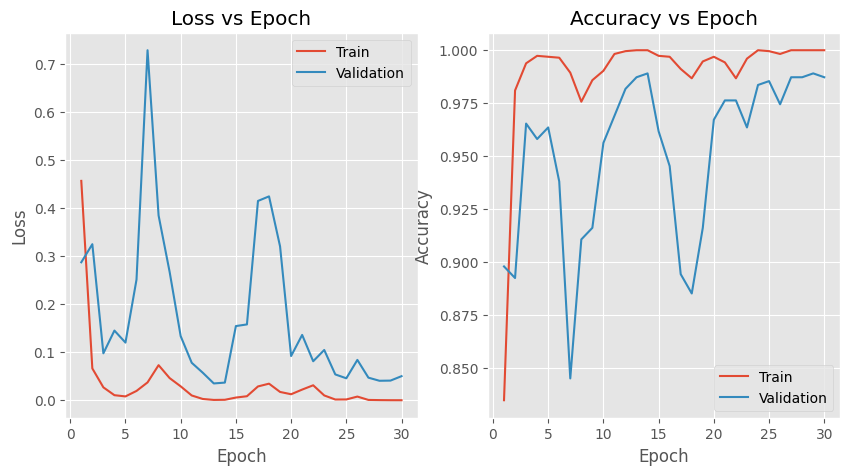

In [17]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train')
plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train')
plt.plot(range(1, num_epochs + 1), validation_accuracies, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()

plt.show()

In [18]:
def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    accuracy = np.sum(np.diag(cm)) / np.sum(cm)
    
    weighted_f1 = f1_score(y_true, y_pred, average='weighted')
    return cm, report, accuracy, weighted_f1

def plot_confusion_matrix(cm, classes):
    with plt.style.context('default'):
        plt.figure(figsize=(5, 5))
        sns.set(font_scale=1.0)
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False, xticklabels=classes, yticklabels=classes)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion matrix')
        plt.show()

C:\Users\jekas\AppData\Local\Temp\ipykernel_25312\2361625626.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))
100%|███

Metrics for current model:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       199
           1       0.98      0.96      0.97        67
           2       1.00      0.99      0.99        74
           3       1.00      0.99      1.00       102
           4       0.97      1.00      0.99       106

    accuracy                           0.99       548
   macro avg       0.99      0.99      0.99       548
weighted avg       0.99      0.99      0.99       548

Test Accuracy: 0.9891


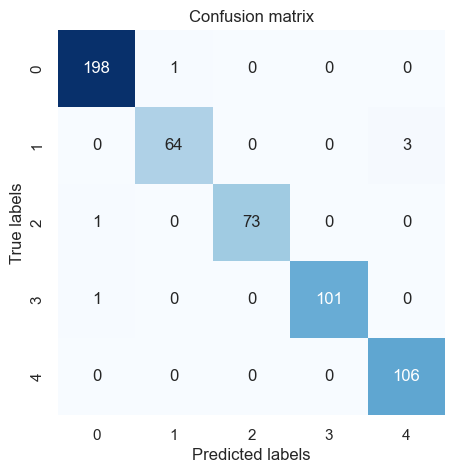

In [19]:
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)

cm, report, accuracy_1, weighted_f1_1 = evaluate_model(model, validation_loader)
print('Metrics for current model:')
print(report)
print(f'Test Accuracy: {accuracy_1:.4f}')
plot_confusion_matrix(cm, classes=list(range(5)))

['Audi', 'Hyundai', 'Rolls Royce', 'Suzuki', 'Tata']

Adding changes to images (Augmentations)

In [20]:
model = models.resnet18(pretrained=True)

num_classes = 5
model.fc = nn.Linear(model.fc.in_features, num_classes)

C:\Users\jekas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\jekas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
train_data_dir = 'carsdataset/train'
validation_data_dir = 'carsdataset/validation'


# Adding data augmentation (RandomRotation, CenterCrop, HorizontalFlip, Normalize)

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(15),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

validation_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Creating datasets
train_dataset = ImageFolder(train_data_dir, transform=train_transforms)
validation_dataset = ImageFolder(validation_data_dir, transform=validation_transforms)

# Creating batches
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

Images with normalization:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.535425].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data

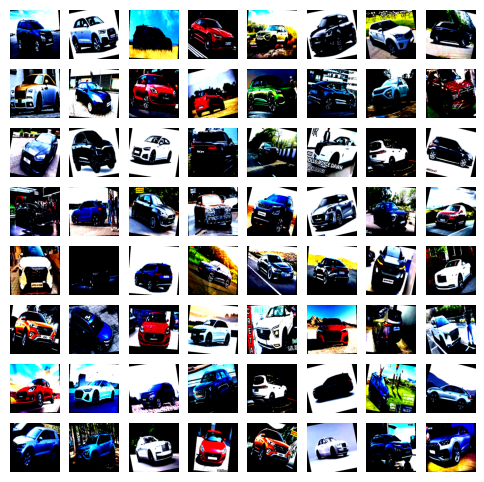

In [22]:
images, _ = next(iter(train_loader))

print('Images with normalization:')
show_images(images, denormalize=False)

Training the model (with augmentation)

In [23]:
# Identical code for training the model

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

num_epochs = 30

train_losses = []
train_accuracies = []

validation_losses = []
validation_accuracies = []
best_validation_accuracy = 0

model.to(device)


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Model validation
    model.eval()
    validation_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(validation_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            validation_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
    validation_loss /= len(validation_loader)
    validation_accuracy = correct / total
    validation_losses.append(validation_loss)
    validation_accuracies.append(validation_accuracy)
    
    print(f'Epoch {epoch + 1}/{num_epochs}', 
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}',
          f'Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}')
    
    # Saving the best model relying on validation accuracy
    if validation_accuracy > best_validation_accuracy:
        best_validation_accuracy = validation_accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        print('Best model saved')
        
    # Saving the last model
    torch.save(model.state_dict(), 'last_model.pth')
    print()
    
print('\nTraining and validation are finished!')
    
    
    

100%|██████████| 9/9 [00:01<00:00,  7.48it/s]


Epoch 1/30 Train Loss: 0.4916, Train Accuracy: 0.8063 Validation Loss: 0.2544, Validation Accuracy: 0.9161
Best model saved



100%|██████████| 9/9 [00:01<00:00,  7.59it/s]


Epoch 2/30 Train Loss: 0.1588, Train Accuracy: 0.9434 Validation Loss: 0.3528, Validation Accuracy: 0.8832



100%|██████████| 9/9 [00:01<00:00,  7.70it/s]


Epoch 3/30 Train Loss: 0.0899, Train Accuracy: 0.9668 Validation Loss: 0.4463, Validation Accuracy: 0.8832



100%|██████████| 9/9 [00:01<00:00,  7.76it/s]


Epoch 4/30 Train Loss: 0.0564, Train Accuracy: 0.9819 Validation Loss: 0.1211, Validation Accuracy: 0.9635
Best model saved



100%|██████████| 9/9 [00:01<00:00,  7.58it/s]


Epoch 5/30 Train Loss: 0.0615, Train Accuracy: 0.9783 Validation Loss: 0.3206, Validation Accuracy: 0.9124



100%|██████████| 9/9 [00:01<00:00,  7.55it/s]


Epoch 6/30 Train Loss: 0.0497, Train Accuracy: 0.9805 Validation Loss: 0.1558, Validation Accuracy: 0.9471



100%|██████████| 9/9 [00:01<00:00,  7.70it/s]


Epoch 7/30 Train Loss: 0.0256, Train Accuracy: 0.9920 Validation Loss: 0.1129, Validation Accuracy: 0.9708
Best model saved



100%|██████████| 9/9 [00:01<00:00,  7.77it/s]


Epoch 8/30 Train Loss: 0.0303, Train Accuracy: 0.9920 Validation Loss: 0.1467, Validation Accuracy: 0.9544



100%|██████████| 9/9 [00:01<00:00,  7.80it/s]


Epoch 9/30 Train Loss: 0.0577, Train Accuracy: 0.9792 Validation Loss: 0.1934, Validation Accuracy: 0.9288



100%|██████████| 9/9 [00:01<00:00,  7.85it/s]


Epoch 10/30 Train Loss: 0.0690, Train Accuracy: 0.9770 Validation Loss: 0.2919, Validation Accuracy: 0.9307



100%|██████████| 9/9 [00:01<00:00,  7.77it/s]


Epoch 11/30 Train Loss: 0.0466, Train Accuracy: 0.9863 Validation Loss: 0.1502, Validation Accuracy: 0.9453



100%|██████████| 9/9 [00:01<00:00,  7.75it/s]


Epoch 12/30 Train Loss: 0.0228, Train Accuracy: 0.9925 Validation Loss: 0.1307, Validation Accuracy: 0.9635



100%|██████████| 9/9 [00:01<00:00,  7.69it/s]


Epoch 13/30 Train Loss: 0.0150, Train Accuracy: 0.9965 Validation Loss: 0.0910, Validation Accuracy: 0.9708



100%|██████████| 9/9 [00:01<00:00,  7.84it/s]


Epoch 14/30 Train Loss: 0.0161, Train Accuracy: 0.9956 Validation Loss: 0.1100, Validation Accuracy: 0.9562



100%|██████████| 9/9 [00:01<00:00,  7.73it/s]


Epoch 15/30 Train Loss: 0.0187, Train Accuracy: 0.9934 Validation Loss: 0.1365, Validation Accuracy: 0.9562



100%|██████████| 9/9 [00:01<00:00,  7.72it/s]


Epoch 16/30 Train Loss: 0.0311, Train Accuracy: 0.9867 Validation Loss: 0.1223, Validation Accuracy: 0.9544



100%|██████████| 9/9 [00:01<00:00,  7.79it/s]


Epoch 17/30 Train Loss: 0.0216, Train Accuracy: 0.9947 Validation Loss: 0.1328, Validation Accuracy: 0.9599



100%|██████████| 9/9 [00:01<00:00,  7.81it/s]


Epoch 18/30 Train Loss: 0.0284, Train Accuracy: 0.9916 Validation Loss: 0.1997, Validation Accuracy: 0.9544



100%|██████████| 9/9 [00:01<00:00,  7.84it/s]


Epoch 19/30 Train Loss: 0.0663, Train Accuracy: 0.9783 Validation Loss: 0.1362, Validation Accuracy: 0.9653



100%|██████████| 9/9 [00:01<00:00,  7.72it/s]


Epoch 20/30 Train Loss: 0.0754, Train Accuracy: 0.9748 Validation Loss: 0.3009, Validation Accuracy: 0.9270



100%|██████████| 9/9 [00:01<00:00,  7.89it/s]


Epoch 21/30 Train Loss: 0.0746, Train Accuracy: 0.9770 Validation Loss: 0.2678, Validation Accuracy: 0.9179



100%|██████████| 9/9 [00:01<00:00,  7.34it/s]


Epoch 22/30 Train Loss: 0.0231, Train Accuracy: 0.9920 Validation Loss: 0.1044, Validation Accuracy: 0.9672



100%|██████████| 9/9 [00:01<00:00,  7.85it/s]


Epoch 23/30 Train Loss: 0.0113, Train Accuracy: 0.9969 Validation Loss: 0.0597, Validation Accuracy: 0.9763
Best model saved



100%|██████████| 9/9 [00:01<00:00,  7.74it/s]


Epoch 24/30 Train Loss: 0.0053, Train Accuracy: 0.9987 Validation Loss: 0.0518, Validation Accuracy: 0.9836
Best model saved



100%|██████████| 9/9 [00:01<00:00,  7.60it/s]


Epoch 25/30 Train Loss: 0.0027, Train Accuracy: 1.0000 Validation Loss: 0.0464, Validation Accuracy: 0.9854
Best model saved



100%|██████████| 9/9 [00:01<00:00,  7.78it/s]


Epoch 26/30 Train Loss: 0.0020, Train Accuracy: 0.9996 Validation Loss: 0.0639, Validation Accuracy: 0.9781



100%|██████████| 9/9 [00:01<00:00,  6.45it/s]


Epoch 27/30 Train Loss: 0.0024, Train Accuracy: 0.9996 Validation Loss: 0.0667, Validation Accuracy: 0.9799



100%|██████████| 9/9 [00:01<00:00,  6.25it/s]


Epoch 28/30 Train Loss: 0.0013, Train Accuracy: 1.0000 Validation Loss: 0.0540, Validation Accuracy: 0.9781



100%|██████████| 9/9 [00:01<00:00,  6.77it/s]


Epoch 29/30 Train Loss: 0.0010, Train Accuracy: 1.0000 Validation Loss: 0.0554, Validation Accuracy: 0.9836



100%|██████████| 9/9 [00:01<00:00,  7.43it/s]

Epoch 30/30 Train Loss: 0.0007, Train Accuracy: 1.0000 Validation Loss: 0.0583, Validation Accuracy: 0.9818


Training and validation are finished!


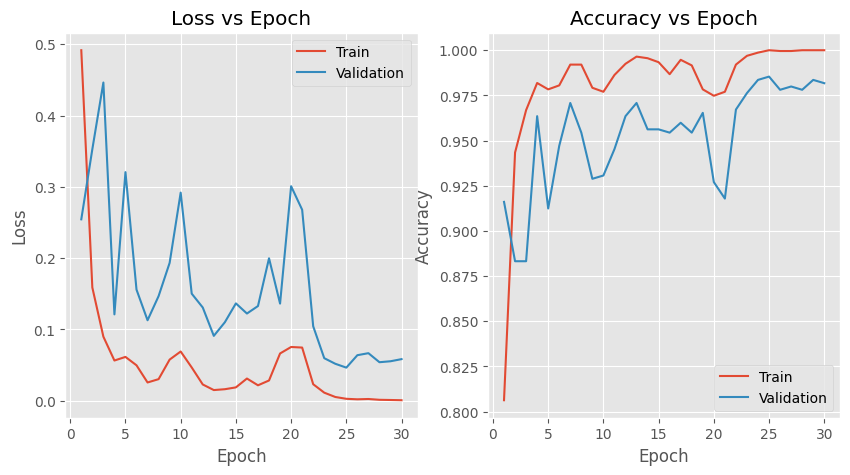

In [24]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train')
plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train')
plt.plot(range(1, num_epochs + 1), validation_accuracies, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()

plt.show()

In [25]:
def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    accuracy = np.sum(np.diag(cm)) / np.sum(cm)
    
    weighted_f1 = f1_score(y_true, y_pred, average='weighted')
    return cm, report, accuracy, weighted_f1

def plot_confusion_matrix(cm, classes):
    with plt.style.context('default'):
        plt.figure(figsize=(5, 5))
        sns.set(font_scale=1.0)
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False, xticklabels=classes, yticklabels=classes)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion matrix')
        plt.show()

C:\Users\jekas\AppData\Local\Temp\ipykernel_25312\2361625626.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))
100%|███

Metrics for current model:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       199
           1       1.00      0.96      0.98        67
           2       0.96      0.97      0.97        74
           3       0.98      0.99      0.99       102
           4       0.99      1.00      1.00       106

    accuracy                           0.99       548
   macro avg       0.98      0.98      0.98       548
weighted avg       0.99      0.99      0.99       548

Test Accuracy: 0.9854


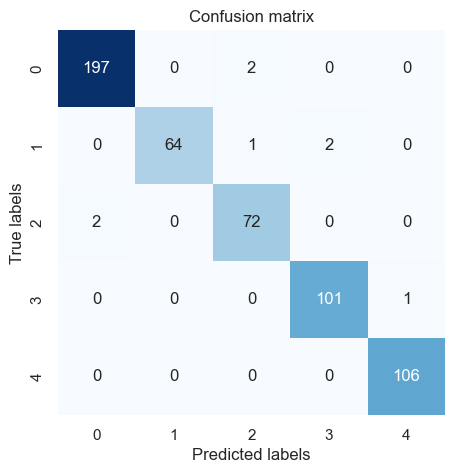

In [26]:
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)

cm, report, accuracy_1, weighted_f1_1 = evaluate_model(model, validation_loader)
print('Metrics for current model:')
print(report)
print(f'Test Accuracy: {accuracy_1:.4f}')
plot_confusion_matrix(cm, classes=list(range(5)))

Using the model

In [27]:
model = models.resnet18()

num_classes = 5
model.fc = nn.Linear(model.fc.in_features, num_classes)


model.load_state_dict(torch.load('best_model.pth'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

C:\Users\jekas\AppData\Local\Temp\ipykernel_25312\2816104761.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Image uploading

tensor([[ 3.4468, -3.9587,  6.6275, -3.3842, -6.2671]], device='cuda:0')
tensor([3.9897e-02, 2.4254e-05, 9.6003e-01, 4.3079e-05, 2.4111e-06])


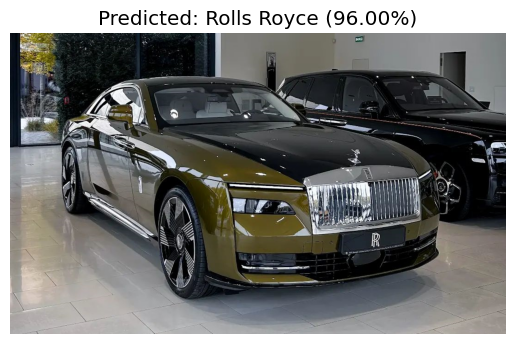

In [34]:
image_path = 'test/3.jpg'
image = Image.open(image_path)
image_tensor = preprocess(image)
image_tensor = image_tensor.unsqueeze(0).to(device) # Adding batch size

# Running the image through the model
with torch.no_grad():
    output = model(image_tensor)
    print(output)
    
# Getting probabilities of all classes
probabilities = torch.nn.functional.softmax(output[0], dim=0).cpu()
print(probabilities)

# Our result class
top_probability, top_class = torch.topk(probabilities, 1)
top_probability = top_probability.item()
top_class = top_class.item()

# Getting the class name
class_names = ['Audi', 'Hyundai', 'Rolls Royce', 'Suzuki', 'Tata']
class_name = class_names[top_class]

plt.imshow(image)
plt.axis('off')
plt.title(f'Predicted: {class_name} ({top_probability*100:.2f}%)')
plt.show() 

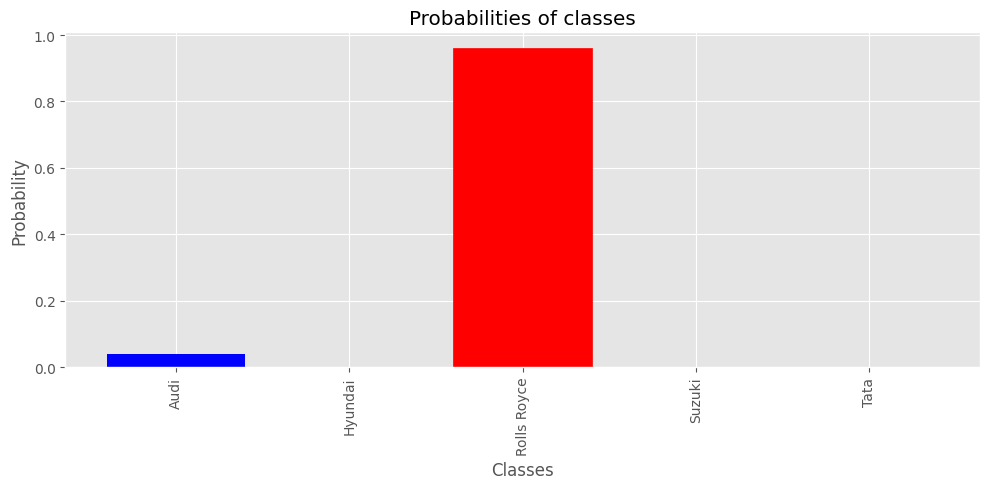

In [35]:
plt.figure(figsize=(10, 5))
bars = plt.bar(range(len(probabilities)), probabilities, color = 'blue')
plt.xlabel('Classes')
plt.ylabel('Probability')
plt.title('Probabilities of classes')
plt.xticks(range(len(probabilities)), class_names, rotation='vertical')

bars[top_class].set_color('red')

plt.tight_layout()
plt.show()